<a id="top"></a>
# Cloud-Filtered Custom Mosaics

<hr>

# Notebook Summary

This notebook can be used to create custom Landsat cloud-filtered mosaics for any time period and location. The mosaics can be output as GeoTIFF products for analysis in external GIS tools. The following mosaics are possible:

Median = midpoint of spectral data  
Geomedian = Australian median product with improved spectral consistency  
Most-Recent = most-recent clear pixel  
Max-NDVI = maximum vegetation response

Users should review the [DCAL Cloud Statistics notebook](DCAL_Cloud_Statistics.ipynb) for more information about the cloud statistics for any given temporal and spatial combination. An understanding of the underlying data is important for creating a valid mosaic for further analyses. In many cases, cloud contamination will create poor mosaics. With a careful review of the cloud coverage over a given region and time period, it is possible to improve the mosaics and avoid false outputs.

<hr>

# Index

* [Import Dependencies and Connect to the Data Cube](#import)
* [Choose Platforms and Products](#plat_prod)
* [Get the Extents of the Cube](#extents)
* [Define the Extents of the Analysis](#define_extents)
* [Load and Clean Data from the Data Cube](#load_data)
* [Create Mosaics](#mosaics)
* [Create GeoTIFF Output Products](#export)

## <span id="import">Import Dependencies and Connect to the Data Cube [&#9652;](#top)</span>

In [1]:
# Enable importing of utilities.
import sys
import os
sys.path.append(os.environ.get('NOTEBOOK_ROOT'))

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import bokeh
import holoviews as hv
import panel as pn
from time import sleep
import datetime
from functools import partial
from dask.diagnostics import Callback
from xarray.ufuncs import isnan as xr_nan
from holoviews.operation.datashader import datashade, rasterize

from utils.data_cube_utilities.dask import create_local_dask_cluster
from utils.data_cube_utilities.dc_load import get_product_extents
from utils.data_cube_utilities.dc_time import dt_to_str
from utils.data_cube_utilities.dc_display_map import display_map
from utils.data_cube_utilities.clean_mask import landsat_qa_clean_mask, landsat_clean_mask_invalid
from utils.data_cube_utilities.dc_mosaic import \
    create_median_mosaic, create_hdmedians_multiple_band_mosaic, \
    create_mosaic, create_min_max_var_mosaic
from utils.data_cube_utilities.vegetation import NDVI
from utils.data_cube_utilities.plotter_utils import figure_ratio
from utils.data_cube_utilities.import_export import export_slice_to_geotiff

# Load Data Cube configuration.
import datacube
import utils.data_cube_utilities.data_access_api as dc_api  
api = dc_api.DataAccessApi()
dc = api.dc

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
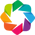

Loading BokehJS ...

In [2]:
# Configure visualization libraries.
pn.extension()
# Use the bokeh backend for HoloViews.
hv.extension('bokeh')
bokeh.io.output_notebook() 

In [3]:
client = create_local_dask_cluster(spare_mem='3Gb')
client

<Client: 'tcp://127.0.0.1:45157' processes=5 threads=10, memory=13.79 GB>

## <span id="plat_prod">Choose Platforms and Products [&#9652;](#top)</span>

<p style="color:red";><b>CHANGE INPUTS BELOW

In [4]:
def get_prods_for_platform(platform):
    prod_info = dc.list_products()
    return list(prod_info.loc[prod_info.platform == platform].name)

platforms = ["LANDSAT_7", "LANDSAT_8"]
platform_wgt = pn.widgets.Select(name='platform', value='LANDSAT_8', options=platforms)
prod_wgt = pn.widgets.Select(name='product', value='ls8_usgs_sr_scene', options=get_prods_for_platform(platform_wgt.value))

@pn.depends(platform_wgt.param.value, watch=True)
def update_prod_list(platform):
    prods = get_prods_for_platform(platform)
    prod_wgt.options = prods
    prod_wgt.value = prods[0] if len(prods) > 0 else None

level, collection = None, None
@pn.depends(prod_wgt.param.value, watch=True)
def update_collection_level(product):
    global level, collection
    level = 'l2'
    if product == 'ls8_usgs_sr_scene':
        collection = 'c1'

pn.Row(platform_wgt, prod_wgt)

Row
    [0] Select(name='platform', options=['LANDSAT_7', ...], value='LANDSAT_8')
    [1] Select(name='product', options=['ls8_usgs_sr_scene'], value='ls8_usgs_sr_scene')

In [5]:
# Update the collection and level to match the selected product.
update_collection_level(prod_wgt.value)

## <span id="extents">Get the Extents of the Cube [&#9652;](#top)</span>

In [6]:
full_lat, full_lon, min_max_dates = get_product_extents(api, platform_wgt.value, prod_wgt.value)

# Print the extents of the combined data.
print("Latitude Extents:", full_lat)
print("Longitude Extents:", full_lon)
print("Time Extents:", list(map(dt_to_str, min_max_dates)))

Latitude Extents: (-6.8445833333880906, 9.723194444522232)
Longitude Extents: (-14.630416666783711, 44.009861111463195)
Time Extents: ['2013-04-12', '2020-01-24']


**Visualize the available area**

In [7]:
display_map(full_lat, full_lon)

## <span id="define_extents">Define the Extents of the Analysis [&#9652;](#top)</span>

<p style="color:red";><b>CHANGE INPUTS BELOW

In [8]:
# Select an analysis region (Lat-Lon) within the extents listed above. 
# HINT: Keep your region small (<0.5 deg square) to avoid memory overload issues
# Select a time period (Min-Max) within the extents

## Location, date, and spatial slider widgets ##

locations = {'Mombasa, Kenya': {'lat': (-4.1131, -3.9853), 'lon': (39.5445, 39.7420)},
         'Freetown, Sierra Leone': {'lat': (8.3267, 8.5123), 'lon': (-13.3109, -13.1197)},
         'Tano-Offin Forest - Ghana': {'lat': (6.5814, 6.8978), 'lon': (-2.2955, -1.9395)},
         'Custom': {}}
location_wgt = pn.widgets.Select(name='Location', value='Mombasa, Kenya', options=list(locations.keys()))
date_wgt = pn.widgets.DateRangeSlider(name='Time Range', start=min_max_dates[0], end=min_max_dates[1], 
                                      value=(datetime.datetime(2016,1,1), datetime.datetime(2016,1,31)))
lat_wgt = pn.widgets.RangeSlider(name='Latitude', start=full_lat[0], end=full_lat[1], step=0.1,
                                 value=locations[location_wgt.value]['lat'])
lon_wgt = pn.widgets.RangeSlider(name='Longitude', start=full_lon[0], end=full_lon[1], step=0.1,
                                 value=locations[location_wgt.value]['lon'])

# If true, denotes that changes in lat/lon are caused by a location widget change,
# not a change in one of the 4 float widgets (lat min, lat max, lon min, lon max).
location_changed = [False]
@pn.depends(location_wgt.param.value, watch=True)
def location_handler(location, location_changed=location_changed):
    # Update the lat/lon sliders with the values for the selected location.
    if location != 'Custom':
        location_changed[0] = True
        lat_wgt.value = locations[location].get('lat', lat_wgt.value)
        lon_wgt.value = locations[location].get('lon', lon_wgt.value)
        location_changed[0] = False

@pn.depends(lat_wgt.param.value, lon_wgt.param.value, watch=True)
def lat_lon_sliders_handler(lat, lon, location_changed=location_changed):
    sleep(0.01)
    # If the latitude or longitude are changed other than due to a newly
    # selected location (location widget), note that this is a custom location.
    if not location_changed[0]:
        location_wgt.value = 'Custom'

## End location, date, and spatial slider widgets ##

## Spatial extents float widgets ##

# Using the `panel.depends` decorator with these widgets in Panel version 0.8.3 does not work.
def set_lat_min_by_flt(evt):
    try:
        lat_min = float(evt.new)
        lat_wgt.value = (lat_min, lat_wgt.value[1])
    except:
        return
lat_min_flt_wgt = pn.widgets.LiteralInput(name='Latitude Min', value=lat_wgt.value[0], type=float)
lat_min_flt_wgt.param.watch(set_lat_min_by_flt, 'value')

def set_lat_max_by_flt(evt):
    try:
        lat_max = float(evt.new)
        lat_wgt.value = (lat_wgt.value[0], lat_max)
    except:
        return
lat_max_flt_wgt = pn.widgets.LiteralInput(name='Latitude Max', value=lat_wgt.value[1], type=float)
lat_max_flt_wgt.param.watch(set_lat_max_by_flt, 'value')

def set_lon_min_by_flt(evt):
    try:
        lon_min = float(evt.new)
        lon_wgt.value = (lon_min, lon_wgt.value[1])
    except:
        return
lon_min_flt_wgt = pn.widgets.LiteralInput(name='Longitude Min', value=lon_wgt.value[0], type=float)
lon_min_flt_wgt.param.watch(set_lon_min_by_flt, 'value')

def set_lon_max_by_flt(evt):
    try:
        lon_max = float(evt.new)
        lon_wgt.value = (lon_wgt.value[0], lon_max)
    except:
        return
lon_max_flt_wgt = pn.widgets.LiteralInput(name='Longitude Max', value=lon_wgt.value[1], type=float)
lon_max_flt_wgt.param.watch(set_lon_max_by_flt, 'value')

## End spatial extents float widgets ##
std_height = 50
std_width = 50
widgets_row_fmt = dict(width=6*std_width)
pn.Row(
    pn.WidgetBox(
        pn.Row(location_wgt, 
               **widgets_row_fmt, height=std_height), 
        pn.Row(date_wgt, 
               **widgets_row_fmt, height=std_height),
        pn.Row(lat_min_flt_wgt, lat_max_flt_wgt, 
               **widgets_row_fmt, height=std_height),
        pn.Row(lat_wgt, 
               **widgets_row_fmt, height=std_height), 
        pn.Row(lon_min_flt_wgt, lon_max_flt_wgt, 
               **widgets_row_fmt, height=std_height),
        pn.Row(lon_wgt, 
               **widgets_row_fmt, height=std_height)),
    pn.WidgetBox("""
       ## Information
       Select a location to set the latitude and longitude sliders. <br><br>
       You can set the area with the numeric widgets. <br><br>
       You can also drag the lower (left) and upper (right) values in the sliders to set the time range and area.""", 
                 **widgets_row_fmt))

Row
    [0] WidgetBox
        [0] Row(height=50, sizing_mode='fixed', width=300)
            [0] Select(name='Location', options=['Mombasa, Kenya', ...], value='Mombasa, Kenya')
        [1] Row(height=50, sizing_mode='fixed', width=300)
            [0] DateRangeSlider(end=datetime.datetime(2020, ..., name='Time Range', start=datetime.datetime(2013, ..., value=(datetime.datetime(2016, ..., value_throttled=(datetime.datetime(2016, ...)
        [2] Row(height=50, sizing_mode='fixed', width=300)
            [0] LiteralInput(name='Latitude Min', type=<class 'float'>, value=-4.1131)
            [1] LiteralInput(name='Latitude Max', type=<class 'float'>, value=-3.9853)
        [3] Row(height=50, sizing_mode='fixed', width=300)
            [0] RangeSlider(end=9.723194444522232, name='Latitude', start=-6.8445833333880906, value=(-4.1131, -3.9853), value_throttled=(-4.1131, -3.9853))
        [4] Row(height=50, sizing_mode='fixed', width=300)
            [0] LiteralInput(name='Longitude Min', type=<class 'float'>, value=39.5445)
            [1] LiteralInput(name='Longitude Max', type=<class 'float'>, value=39.742)
        [5] Row(height=50, sizing_mode='fixed', width=300)
            [0] RangeSlider(end=44.009861111463195, name='Longitude', start=-14.630416666783711, value=(39.5445, 39.742), value_throttled=(39.5445, 39.742))
    [1] WidgetBox(width=300)
        [0] Markdown(str)

**Visualize the selected area**

In [9]:
display_map(lat_wgt.value,lon_wgt.value)

## <span id="load_data">Load and Clean Data from the Data Cube [&#9652;](#top)</span>

In [10]:
measurements = ['red', 'green', 'blue', 'nir', 'swir1', 'swir2', 'pixel_qa']
landsat_dataset = dc.load(latitude = lat_wgt.value,
                          longitude = lon_wgt.value,
                          platform = platform_wgt.value,
                          time = date_wgt.value,
                          product = prod_wgt.value,
                          measurements = measurements,
                          group_by='solar_day', 
                          dask_chunks={'latitude':500, 'longitude':500, 'time':1})

In [11]:
# Displays the first few values of each data array to check the content
# Latitude and Longitude numbers = number of pixels in each dimension
# Time = number of time slices in the dataset

landsat_dataset

<xarray.Dataset>
Dimensions:      (latitude: 461, longitude: 712, time: 19)
Coordinates:
  * time         (time) datetime64[ns] 2016-01-10T07:31:41.510529 ... 2016-12...
  * latitude     (latitude) float64 -3.985 -3.986 -3.986 ... -4.113 -4.113
  * longitude    (longitude) float64 39.54 39.54 39.55 ... 39.74 39.74 39.74
    spatial_ref  int32 4326
Data variables:
    red          (time, latitude, longitude) int16 dask.array<chunksize=(1, 461, 500), meta=np.ndarray>
    green        (time, latitude, longitude) int16 dask.array<chunksize=(1, 461, 500), meta=np.ndarray>
    blue         (time, latitude, longitude) int16 dask.array<chunksize=(1, 461, 500), meta=np.ndarray>
    nir          (time, latitude, longitude) int16 dask.array<chunksize=(1, 461, 500), meta=np.ndarray>
    swir1        (time, latitude, longitude) int16 dask.array<chunksize=(1, 461, 500), meta=np.ndarray>
    swir2        (time, latitude, longitude) int16 dask.array<chunksize=(1, 461, 500), meta=np.ndarray>
    pixel_qa     (time, latitude, longitude) uint16 dask.array<chunksize=(1, 461, 500), meta=np.ndarray>
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref

**Mask out clouds**

In [12]:
plt_col_lvl_params = dict(platform=platform_wgt.value, collection=collection, level=level)
cloud_mask = (landsat_qa_clean_mask(landsat_dataset, **plt_col_lvl_params) & \
             (landsat_dataset != -9999).to_array().any('variable') & \
             landsat_clean_mask_invalid(landsat_dataset, **plt_col_lvl_params))
cleaned_dataset = landsat_dataset.where(cloud_mask).drop('pixel_qa')

In [13]:
cloud_mask = cloud_mask.persist()
cleaned_dataset = cleaned_dataset.persist()

## <span id="mosaics">Create Mosaics [&#9652;](#top)</span>

> **Median Mosaic**  
>  Masks clouds from imagery using the median-valued cloud-free pixels in the time series.
>  More specifically, each band (e.g. red) of each pixel is assigned its median across time.
>  So this mosaic method generates values that are not in the dataset.

> **Geomedian Mosaic**  
>  Masks clouds from imagery using the geomedian-valued cloud-free pixels in the time series, which maintains the spectral band relationships. 
> That is, this is a median through time for all bands considered collectively rather than separately, as is the case in a median mosaic.
> This algorithm was developed by Geoscience Australia and produces excellent cloud-filtered mosaic products for further analysis. 
<br><br>
For more information, see the following paper: High-Dimensional Pixel Composites from Earth Observation Time Series, by, Dale Roberts, Norman Mueller, and Alexis McIntyre. IEEE Transactions on Geoscience and Remote Sensing, Vol. 55. No. 11, November 2017.

> **Most Recent and Least Recent Mosaic**  
>  Masks clouds from imagery using the most or least recent cloud-free pixels in the time series. 

> **Max NDVI Mosaic**  
>  Masks clouds from imagery using the maximum NDVI across time for cloud-free pixels in the time series. The max NDVI mosaic will represent the highest amount of green vegetation for each pixel.

In [14]:
mosaic_methods = {'Median': create_median_mosaic, 
                  'Geomedian': create_hdmedians_multiple_band_mosaic, 
                  'Most Recent': create_mosaic, 
                  'Least Recent': partial(create_mosaic, reverse_time=True), 
                  'Max NDVI': partial(create_min_max_var_mosaic, var='NDVI', min_max='max')}
mosaic_methods_wgt = pn.widgets.RadioButtonGroup(
    value='Median', options=list(mosaic_methods.keys()))

computing_composite = [False]
composites = {}
composite_rgbs = {}
selected_composite_type = [None]
prev_plat = [platform_wgt.value]
prev_prod = [prod_wgt.value]
prev_time = [date_wgt.value]
prev_lat = [lat_wgt.value]
prev_lon = [lon_wgt.value]
@pn.depends(mosaic_method_name=mosaic_methods_wgt.param.value)
def mosaic(mosaic_method_name, **kwargs):
    computing_composite[0] = True
    # Create the composite if we have not already.
    selected_composite_type[0] = mosaic_method_name.lower().replace(' ', '_')
    # If the time or lat/lon extents have changed, clear the composites.
    if prev_plat[0] != platform_wgt.value or prev_prod[0] != prod_wgt.value or \
       prev_time[0] != date_wgt.value or prev_lat[0] != lat_wgt.value or prev_lon[0] != lon_wgt.value:
        for composite_type in list(composites.keys()):
            del composites[composite_type]
    prev_plat[0] = platform_wgt.value
    prev_prod[0] = prod_wgt.value
    prev_time[0] = date_wgt.value
    prev_lat[0] = lat_wgt.value
    prev_lon[0] = lon_wgt.value
    
    if selected_composite_type[0] not in composites:
        if mosaic_method_name == 'Max NDVI':
            cleaned_dataset['NDVI'] = NDVI(cleaned_dataset)
        composites[selected_composite_type[0]] = mosaic_methods[mosaic_method_name](cleaned_dataset, cloud_mask).persist()
    computing_composite[0] = False
    # Create the RGB image.
    if selected_composite_type[0] not in composite_rgbs:
        rgb = composites[selected_composite_type[0]][['red', 'green', 'blue']].to_array().transpose('latitude', 'longitude', 'variable')
        rgb_scaled = (rgb - rgb.min()) / (rgb.max() - rgb.min())
        composite_rgbs[selected_composite_type[0]] = rgb_scaled.where(~xr_nan(rgb_scaled), 0).persist()
    
    return hv.RGB(composite_rgbs[selected_composite_type[0]], kdims=['longitude', 'latitude'])

width, height = figure_ratio(cleaned_dataset, fixed_width=800)
width, height = int(width), int(height)
dmap = hv.DynamicMap(mosaic)
pn.Column(pn.WidgetBox("## Mosaics to Compare", mosaic_methods_wgt, width=width), 
          rasterize(dmap).opts(height=height, width=width))

Column
    [0] WidgetBox(width=800)
        [0] Markdown(str)
        [1] RadioButtonGroup(options=['Median', 'Geomedian', ...], value='Median')
    [1] HoloViews(DynamicMap)

## <span id="export">Create GeoTIFF Output Products [&#9652;](#top)</span>

**Only the composites that were selected at least once above for the currently selected area will be exported**

In [15]:
# Wait for the composite to be obtained.
while computing_composite[0]:
    sleep(1)

output_dir = 'output/geotiffs/custom_mosaics'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
for composite_type in composites:
    export_slice_to_geotiff(composites[composite_type], f'{output_dir}/{composite_type}_composite.tif')

**See the exported GeoTIFF files**

In [16]:
!ls -lah output/geotiffs/custom_mosaics

total 7.6M
drwxr-xr-x 2 jovyan  1000 4.0K Feb  8 21:17 .
drwxr-xr-x 3 jovyan  1000 4.0K Feb  8 21:15 ..
-rw-r--r-- 1 jovyan users 7.6M Feb  8 21:17 median_composite.tif
